In [1]:
"""NLTKのGutenbergコーパスを用いた著者判定の分析を行うモジュール"""

import re
from re import Match
from typing import Final, TypeAlias

import nltk
import numpy as np
import shap
import pandas as pd
from nltk.corpus import gutenberg
from pandas import DataFrame

from authorship_tool.type_alias import Para, Tag
from authorship_tool.util import (
    LGBMResultModel,
    LGBMSourceModel,
    ArrayDimensionReshaper,
    FeatureDatasetGenerator,
    PosFeature,
    TypeGuardUtil,
    LGBMTrainerUtil,
    PathUtil,
)

# 必要に応じてダウンロード
# nltk.download("gutenberg")
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")
# nltk.download("stopwords")

Project root: /workspaces/shap-authorship-analysis-demo
Path: path_dump_lgbm_model_dir = /dump/lgbm/model
Path: path_dump_dataset_dir = /dump/dataset
Path: path_dump_shap_figure_dir = /dump/shap/figure
Path: path_adjective_past_participle_dataset = /lib/nlp_datasets/wordLists/adjectivesPastParticiple
File: '/lib/nlp_datasets/wordLists/adjectivesPastParticiple' could not be found. Skip and continue processing.


In [2]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [3]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors = set(
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
)

para_size_by_author: dict[Author, NumOfParas] = dict()

for index, author in enumerate(iterable=authors):
    books: list[list[Para]] = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda bsba: bsba[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [4]:
AUTHOR_A: Final[str] = "chesterton"

books_a: list[list[Para]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: list[Para] = [para for paras in books_a for para in paras]
if len(paras_a) == 0 or not TypeGuardUtil.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[list[str]]")

for para in paras_a[:10]:
    print(ArrayDimensionReshaper.para2str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [5]:
AUTHOR_B: Final[str] = "austen"

books_b: list[list[Para]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: list[Para] = [para for paras in books_b for para in paras]
if len(paras_b) == 0 or not TypeGuardUtil.are_paras(paras_b):
    raise ValueError("paras_a is empty or not list[list[str]]")

for para in paras_b[:10]:
    print(ArrayDimensionReshaper.para2str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

[ Emma by Jane Austen 1816 ]
VOLUME I
CHAPTER I
Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .
She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period . Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .
Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma . Between _them_ it was more the intimacy of sisters . Even before Miss Taylor had ceased to hold the nominal office of gover

In [6]:
if not (TypeGuardUtil.are_paras(paras_a) and TypeGuardUtil.are_paras(paras_b)):
    raise TypeError("paras_a or paras_b is not list[list[list[str]]] type.")
all_paras: list[Para] = paras_a + paras_b


pos_list: list[Tag] = PosFeature(all_paras).tag_subcategories().pos_list


print(pos_list)

['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [7]:
dataset_generator = FeatureDatasetGenerator(pos_list)
data: list[tuple[float, ...]] = []
correctness: list[bool] = []

for para_a in paras_a:
    (x, y) = dataset_generator.generate_from_paragraph(para_a, True)
    data.append(x)
    correctness.append(y)

for para_b in paras_b:
    (x, y) = dataset_generator.generate_from_paragraph(para_b, False)
    data.append(x)
    correctness.append(y)

In [8]:
df = DataFrame(data, columns=dataset_generator.columns)
nd_correctness = np.array(correctness)

pd.set_option("display.max_columns", 1000)
display(df.head(10))
pd.reset_option("display.max_columns")

,word variation,uncommon word frequency,sentence length,average word length,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0.857143,0.857143,14,2.857143,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.071429,0.142857,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000,1.000000,8,3.625000,0.0,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.573171,0.530488,164,4.103659,0.0,0.0,0.000000,0.000000,0.042683,0.030488,0.018293,0.006098,0.006098,0.006098,0.000000,0.006098,0.006098,0.006098,0.006098,0.000000,0.000000,0.006098,0.006098,0.000000,0.006098,0.000000,0.000000,0.006098,0.000000,0.006098,0.000000,0.000000,0.000000,0.0,0.024390,0.0,0.006098,0.018293,0.006098,0.012195,0.006098,0.006098,0.006098,0.0,0.000000,0.000000,0.0
3,0.637584,0.590604,149,4.389262,0.0,0.0,0.000000,0.000000,0.067114,0.040268,0.006711,0.006711,0.006711,0.006711,0.000000,0.000000,0.006711,0.006711,0.000000,0.006711,0.006711,0.006711,0.006711,0.000000,0.006711,0.013423,0.000000,0.006711,0.013423,0.006711,0.000000,0.000000,0.000000,0.0,0.020134,0.0,0.006711,0.006711,0.006711,0.006711,0.006711,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,0.544218,0.574830,294,4.125850,0.0,0.0,0.003401,0.003401,0.085034,0.027211,0.003401,0.003401,0.003401,0.003401,0.003401,0.000000,0.003401,0.006803,0.000000,0.000000,0.003401,0.003401,0.003401,0.003401,0.003401,0.003401,0.000000,0.003401,0.003401,0.003401,0.000000,0.003401,0.003401,0.0,0.017007,0.0,0.003401,0.006803,0.003401,0.003401,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,0.758242,0.593407,91,4.637363,0.0,0.0,0.000000,0.000000,0.032967,0.043956,0.000000,0.021978,0.000000,0.010989,0.000000,0.000000,0.010989,0.010989,0.000000,0.000000,0.010989,0.010989,0.010989,0.000000,0.010989,0.000000,0.000000,0.010989,0.010989,0.010989,0.000000,0.000000,0.000000,0.0,0.054945,0.0,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.0,0.000000,0.000000,0.0
6,0.860000,0.580000,50,3.480000,0.0,0.0,0.000000,0.000000,0.040000,0.000000,0.020000,0.020000,0.000000,0.020000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.020000,0.020000,0.020000,0.000000,0.020000,0.000000,0.000000,0.020000,0.020000,0.020000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.020000,0.020000,0.000000,0.000000,0.020000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7,0.485623,0.555911,313,3.638978,0.0,0.0,0.003195,0.000000,0.089457,0.041534,0.000000,0.003195,0.000000,0.006390,0.003195,0.000000,0.003195,0.003195,0.006390,0.003195,0.003195,0.003195,0.003195,0.000000,0.003195,0.003195,0.003195,0.003195,0.003195,0.003195,0.003195,0.000000,0.000000,0.0,0.006390,0.0,0.003195,0.003195,0.000000,0.003195,0.003195,0.006390,0.006390,0.0,0.000000,0.003195,0.0
8,0.840000,0.680000,25,3.760000,0.0,0.0,0.000000,0.000000,0.080000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.040000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000,0.080000,0.040000,0.040000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.040000,0.040000,0.040000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
9,0.840000,0.800000,25,3.400000,0.0,0.0,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.040000,0.000000,0.000000,0.040000,0.040000,0.040000,0.000000,0.000000

In [9]:
print(df.shape)

(9320, 47)


In [10]:
print(df.dtypes)

word variation             float64
uncommon word frequency    float64
sentence length              int64
average word length        float64
$                          float64
''                         float64
(                          float64
)                          float64
,                          float64
.                          float64
:                          float64
CC                         float64
CD                         float64
DT                         float64
EX                         float64
FW                         float64
IN                         float64
JJ                         float64
JJR                        float64
JJS                        float64
MD                         float64
NN                         float64
NNP                        float64
NNPS                       float64
NNS                        float64
PDT                        float64
POS                        float64
PRP                        float64
PRP$                

In [11]:
print(df.isna().sum())

word variation             0
uncommon word frequency    0
sentence length            0
average word length        0
$                          0
''                         0
(                          0
)                          0
,                          0
.                          0
:                          0
CC                         0
CD                         0
DT                         0
EX                         0
FW                         0
IN                         0
JJ                         0
JJR                        0
JJS                        0
MD                         0
NN                         0
NNP                        0
NNPS                       0
NNS                        0
PDT                        0
POS                        0
PRP                        0
PRP$                       0
RB                         0
RBR                        0
RBS                        0
RP                         0
SYM                        0
TO            

In [12]:
DESIRED_SCORE: Final[float] = 0.88

result: LGBMResultModel = LGBMTrainerUtil.learn_until_succeed(
    LGBMSourceModel(DESIRED_SCORE, df, nd_correctness)
)

[LightGBM] [Info] Number of positive: 3041, number of negative: 3949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9545
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435050 -> initscore=-0.261276
[LightGBM] [Info] Start training from score -0.261276
[LightGBM] [Info] Number of positive: 3092, number of negative: 3898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9552
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442346 -> initscore=-0.231645
[LightGB

[LightGBM] [Info] Number of positive: 3063, number of negative: 3927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9542
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.438197 -> initscore=-0.248481
[LightGBM] [Info] Start training from score -0.248481
[LightGBM] [Info] Number of positive: 3042, number of negative: 3948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9530
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435193 -> initscore=-0.260694
[LightGBM] [Info] Start training from score -0.260694
[LightGBM] [Info] 

In [13]:
print(f"auc-roc score: {result.auc_roc_score}")

auc-roc score: 0.8855543698820931


In [14]:
display(result.pred_crosstab())

col_0,False,True
row_0,,
False,1126,196
True,267,741


In [15]:
result.dump()

PermissionError: [Errno 13] Permission denied: '/dump'

In [ ]:
explainer = shap.explainers.TreeExplainer(result.model)
test_shap_val = explainer.shap_values(result.test_data)[1]

DataFrame(test_shap_val).to_csv(
    PathUtil.DATASET_DIR.joinpath("test_shap_val.csv"), index=False, header=False
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
# shap.initjs()

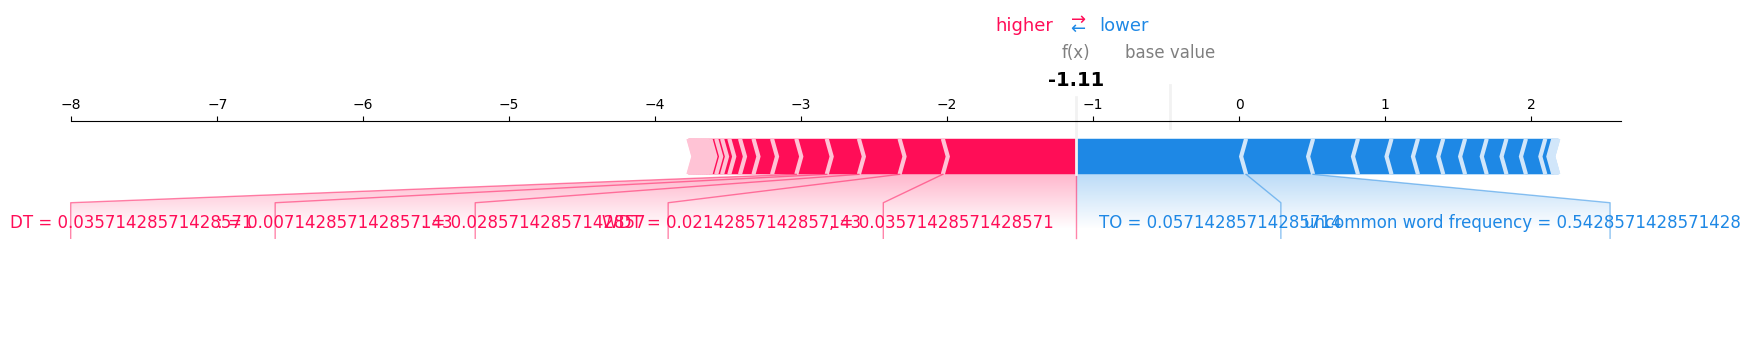

In [ ]:
shap.force_plot(
    explainer.expected_value[1],
    test_shap_val[0],
    result.test_data.iloc[0],
    matplotlib=True,
)

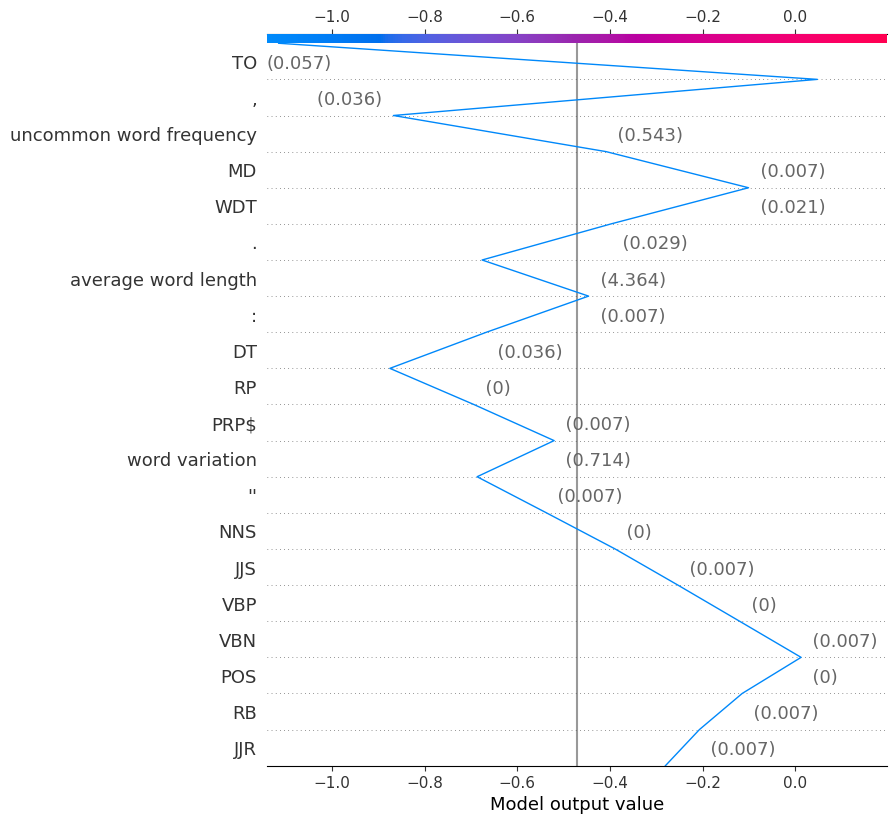

In [ ]:
shap.decision_plot(
    explainer.expected_value[1], test_shap_val[0], result.test_data.iloc[0]
)

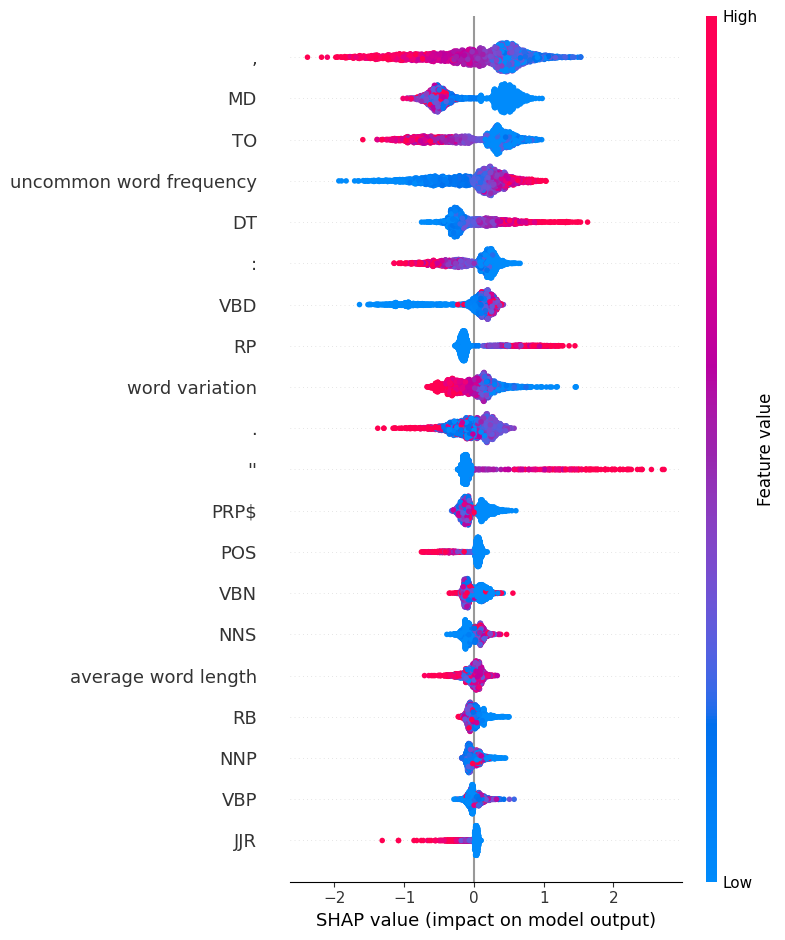

In [ ]:
shap.summary_plot(test_shap_val, result.test_data)

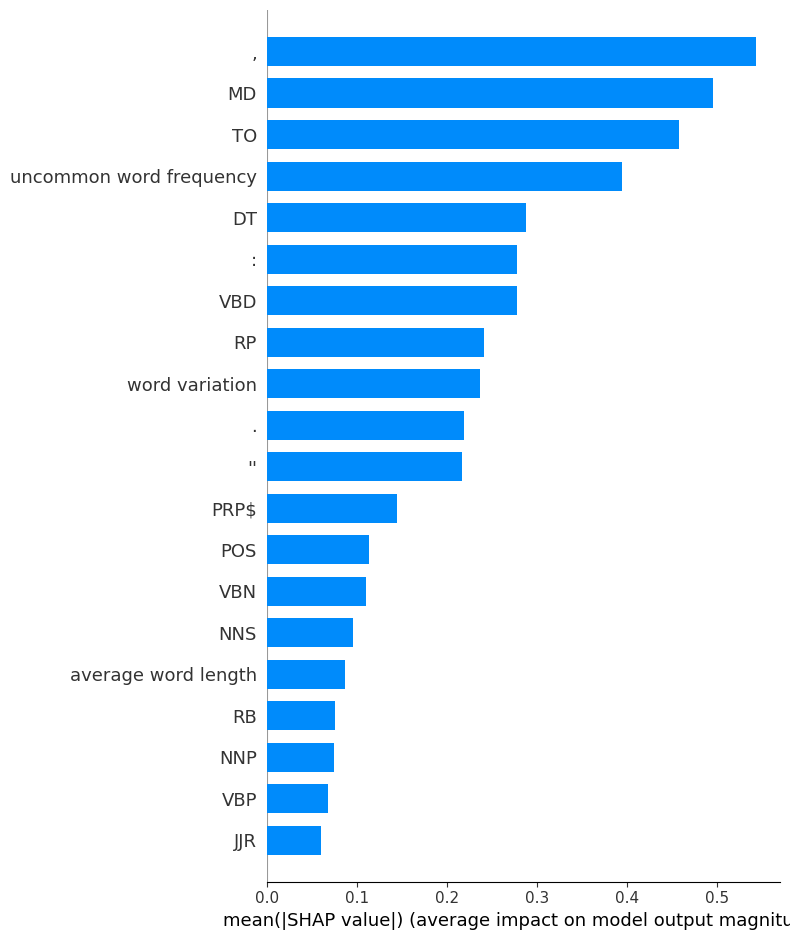

In [ ]:
shap.summary_plot(test_shap_val, result.test_data, plot_type="bar")